<a href="https://colab.research.google.com/github/jianfeiZhao/BI_projs/blob/master/stocks_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 中国石化走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('./stock.csv')
df = df[['Timestamp', 'Price']]

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
df.replace(0, np.nan, inplace=True)
df = df.dropna()
# 数据探索
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Timestamp,Price
Timestamp,,
2020-07-13,2020-07-13,4.13
2020-07-10,2020-07-10,4.20
2020-07-09,2020-07-09,4.20
2020-07-08,2020-07-08,4.21
2020-07-07,2020-07-07,4.31


In [ ]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
df_month.head()

,Price
Timestamp,
2001-08-31,4.208824
2001-09-30,3.943500
2001-10-31,3.807778
2001-11-30,3.672727
2001-12-31,3.506190


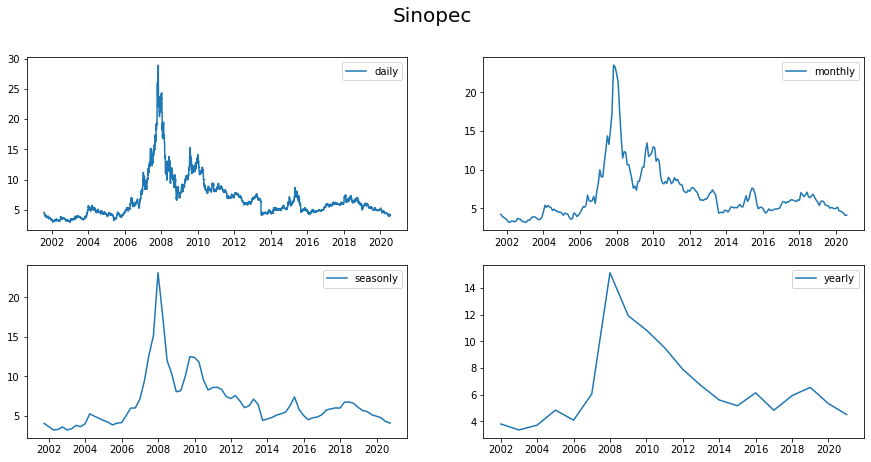

In [ ]:
# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Sinopec', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='daily')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='monthly')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='seasonly')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='yearly')
plt.legend()
plt.show()

参数错误: (0, 2)


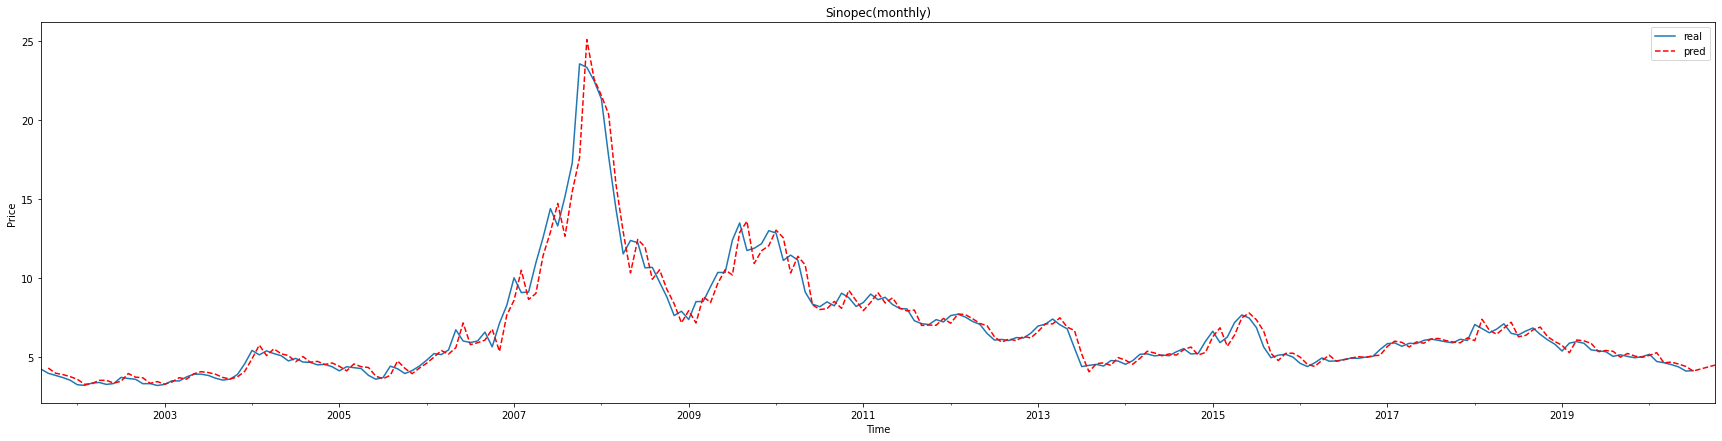

In [ ]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs) # 排列组合
parameters_list = list(parameters)
# 寻找最优ARMA模型参数
results = []
best_aic = float("inf") 
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
#print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
#print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
#print(df_month2)

# 中国石化预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='real')
df_month2.forecast.plot(color='r', ls='--', label='pred')
plt.legend()
plt.title('Sinopec(monthly)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [ ]:
# 使用LSTM预测中国石化股票
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 转化为可以用于监督学习的数据
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    #print(reframed_train_data_set)
    #print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# 使用LSTM进行预测
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 第一层, 隐藏层神经元节点个数为128, 返回整个序列
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 第三层 因为是回归问题所以使用linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM训练 input_epochs次数, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    #print(model.summary())
    plot_img(source_data_set, train_predict)

# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

Epoch 1/300
 - 1s - loss: 57.9551
Epoch 2/300
 - 0s - loss: 53.7260
Epoch 3/300
 - 0s - loss: 48.7038
Epoch 4/300
 - 0s - loss: 41.9437
Epoch 5/300
 - 0s - loss: 33.6294
Epoch 6/300
 - 0s - loss: 23.6781
Epoch 7/300
 - 0s - loss: 15.3713
Epoch 8/300
 - 0s - loss: 11.7172
Epoch 9/300
 - 0s - loss: 11.1067
Epoch 10/300
 - 0s - loss: 10.6303
Epoch 11/300
 - 0s - loss: 11.4825
Epoch 12/300
 - 0s - loss: 11.1077
Epoch 13/300
 - 0s - loss: 10.1277
Epoch 14/300
 - 0s - loss: 10.7016
Epoch 15/300
 - 0s - loss: 10.1473
Epoch 16/300
 - 0s - loss: 10.2341
Epoch 17/300
 - 0s - loss: 10.2399
Epoch 18/300
 - 0s - loss: 10.4978
Epoch 19/300
 - 0s - loss: 9.5006
Epoch 20/300
 - 0s - loss: 9.6559
Epoch 21/300
 - 0s - loss: 8.9494
Epoch 22/300
 - 0s - loss: 8.3817
Epoch 23/300
 - 0s - loss: 7.8132
Epoch 24/300
 - 0s - loss: 8.1790
Epoch 25/300
 - 0s - loss: 8.0595
Epoch 26/300
 - 0s - loss: 7.8839
Epoch 27/300
 - 0s - loss: 7.4090
Epoch 28/300
 - 0s - loss: 6.8844
Epoch 29/300
 - 0s - loss: 6.8189
Epoch

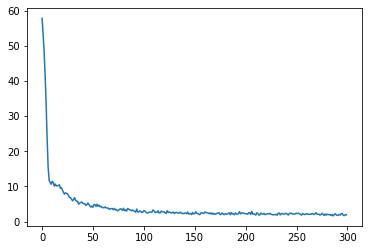

No handles with labels found to put in legend.


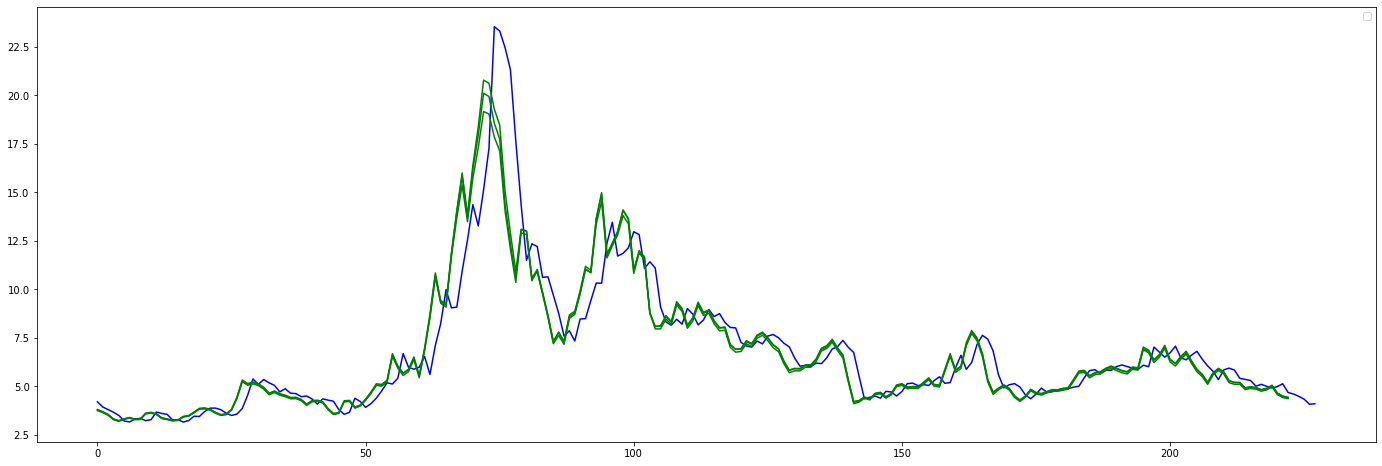

In [ ]:
# 按月预测
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 300
batch_size = 100

df = pd.read_csv('./stock.csv')
df = df[['Timestamp', 'Price']]

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
df.replace(0, np.nan, inplace=True)
df = df.dropna()
data_month = df.resample('M').mean()
data_set = data_month[['Price']].values.astype('float64')
# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# 使用LSTM进行训练、预测
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

Epoch 1/200
 - 1s - loss: 19.4034
Epoch 2/200
 - 1s - loss: 11.6760
Epoch 3/200
 - 1s - loss: 7.7891
Epoch 4/200
 - 1s - loss: 5.5917
Epoch 5/200
 - 1s - loss: 4.4367
Epoch 6/200
 - 1s - loss: 3.8215
Epoch 7/200
 - 1s - loss: 3.5800
Epoch 8/200
 - 1s - loss: 3.3680
Epoch 9/200
 - 1s - loss: 3.2700
Epoch 10/200
 - 1s - loss: 3.1336
Epoch 11/200
 - 1s - loss: 2.9574
Epoch 12/200
 - 1s - loss: 2.7688
Epoch 13/200
 - 1s - loss: 2.7379
Epoch 14/200
 - 1s - loss: 2.4759
Epoch 15/200
 - 1s - loss: 2.4063
Epoch 16/200
 - 1s - loss: 2.3081
Epoch 17/200
 - 1s - loss: 2.1524
Epoch 18/200
 - 1s - loss: 2.0304
Epoch 19/200
 - 1s - loss: 1.9357
Epoch 20/200
 - 1s - loss: 1.8198
Epoch 21/200
 - 1s - loss: 1.6127
Epoch 22/200
 - 1s - loss: 1.5027
Epoch 23/200
 - 1s - loss: 1.5583
Epoch 24/200
 - 1s - loss: 1.5692
Epoch 25/200
 - 1s - loss: 1.7394
Epoch 26/200
 - 1s - loss: 1.5845
Epoch 27/200
 - 1s - loss: 1.5571
Epoch 28/200
 - 1s - loss: 1.3440
Epoch 29/200
 - 1s - loss: 1.2646
Epoch 30/200
 - 1s - 

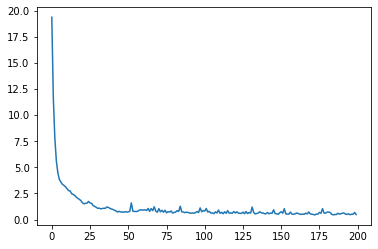

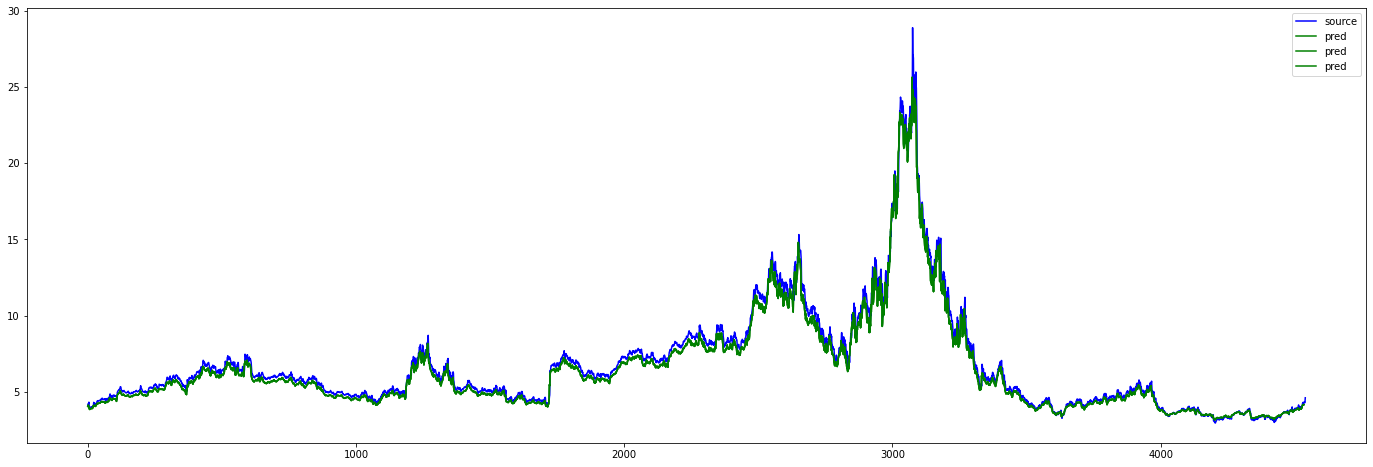

In [ ]:
# 按天预测
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 200
batch_size = 100
data_set = df[['Price']].values.astype('float64')

# 转化为可以用于监督学习的数据
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# 使用LSTM进行训练、预测
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

In [ ]:
# 使用prophet预测
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

# 数据加载
df = pd.read_csv('./stock.csv')
df = df[['Timestamp', 'Price']]

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
df.replace(0, np.nan, inplace=True)
df = df.dropna()
df['ds'] = df.index
df['y'] = df.Price
df.drop(['Price', 'Timestamp'], axis=1, inplace=True)
df.head()

,ds,y
Timestamp,,
2020-07-13,2020-07-13,4.13
2020-07-10,2020-07-10,4.20
2020-07-09,2020-07-09,4.20
2020-07-08,2020-07-08,4.21
2020-07-07,2020-07-07,4.31


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


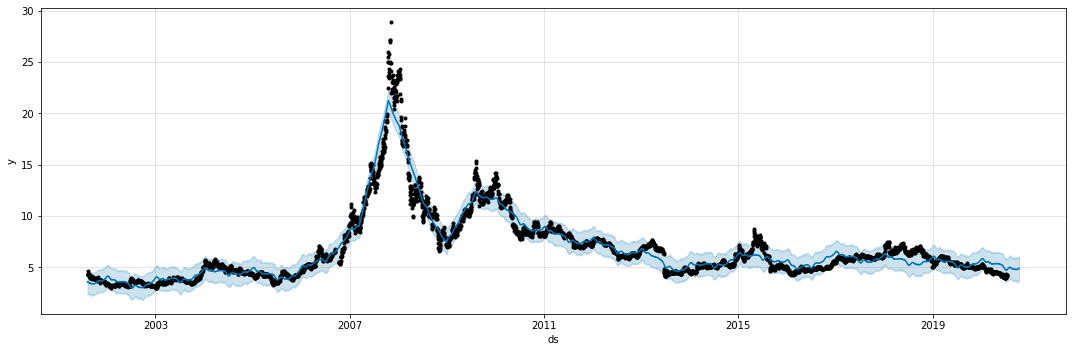

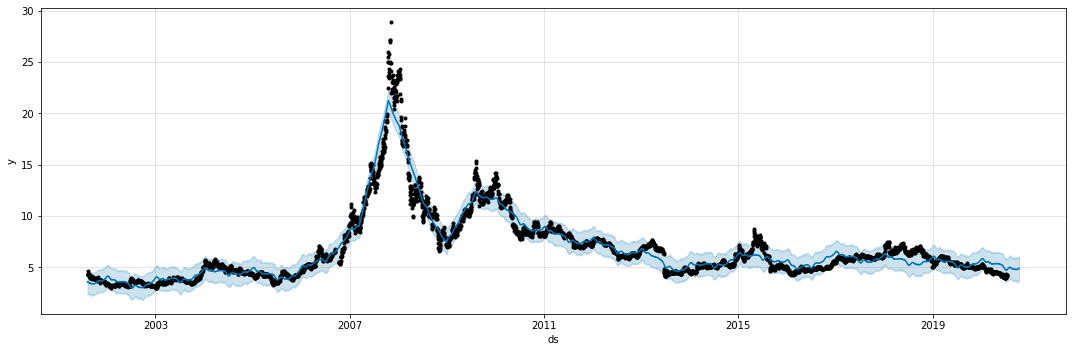

In [ ]:
m = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)
m.fit(df)
# predict the following 3 months, 90 days
future = m.make_future_dataframe(periods=90)
# predict
forcast = m.predict(future)
m.plot(forcast, figsize=(15,5))

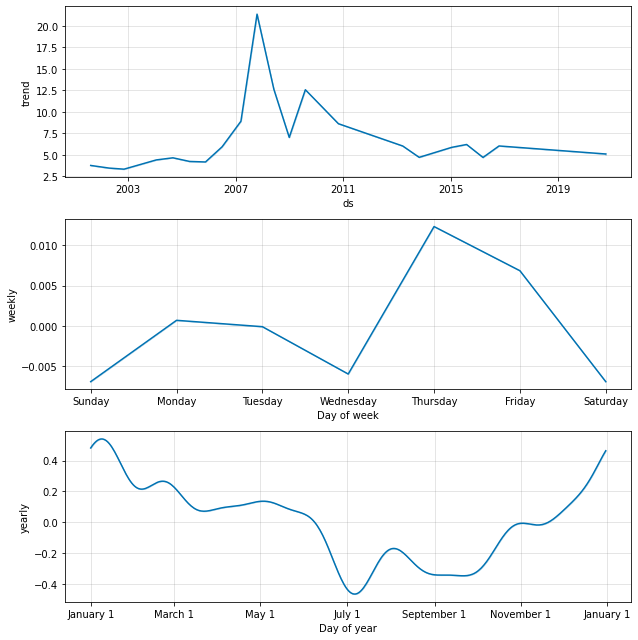

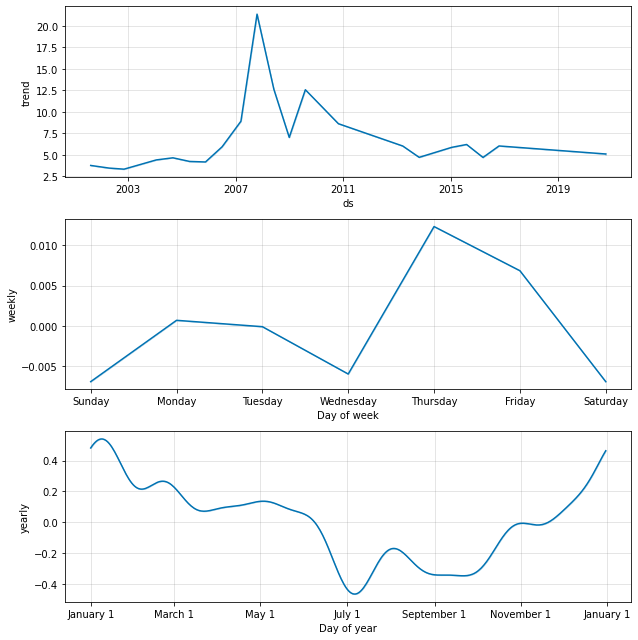

In [ ]:
m.plot_components(forcast)